## RAS Document Classification

Andrew Mao

* train baseline classifiers on RAS guidance documents, using tf-idf and topic model features. 
* simulate online learning and active learning
* error analysis: confusion matrix, precision/recall by class

Questions we try to answer:
* do topic model features improve performance?
* which model performs best in the online setting? 
* Does active learning work?
* Is the model confidence sensible?
* How accurate is the labelled/supervised topic model?


Reference codes from "All Roads Lead to Resilience? A Structured Comparison of Community-Oriented
Guidance for Resilience, Climate Adaptation, and Sustainability Planning"

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk

nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /cliphomes/amao1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /cliphomes/amao1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# the data is Juan's csv with dropped duplicates, to ensure consistency when joining with topic model features

# data_path = "data/corpus_guidance.csv"
data_path = "data/nist_ras_documents_cleaned.csv"
df = pd.read_csv(data_path)
df

,Unnamed: 0,text,tag_0,tag_1,tag_2,source,group,doc_id,dominant_topic,dominant_topic_percent,topic_keywords,manual_label,predicted_label,prediction_score,uncertainty_score
0,0,Appendix B: Federal Laws and Executive Orders...,IMPLEMENTATION AND MONITORING,Plan Compliance and Integration,NaN,A5 - NOAA Coastal Management 2010 adaptationguide,Climate Adaptation,0,19.0,0.0951,"climate, change, adaptation, tribe, resource, ...",NaN,NaN,NaN,NaN
1,1,Appendix C: Regional Climate Change Summaries,FACT BASE,Fact Base (general),Hazards,A5 - NOAA Coastal Management 2010 adaptationguide,Climate Adaptation,1,19.0,0.0960,"climate, change, adaptation, tribe, resource, ...",NaN,NaN,NaN,NaN
2,2,Adaptation: The adjustment of natural or human...,GUIDE PURPOSE AND OBJECTIVES,Term definition,NaN,A8 - CA 2012 Adapting to Sea Level Rise,Climate Adaptation,2,0.0,0.0800,"water, reduce, system, natural, energy, manage...",NaN,NaN,NaN,NaN
3,3,Adaptive capacity: A communitys ability to re-...,GUIDE PURPOSE AND OBJECTIVES,Term definition,NaN,A8 - CA 2012 Adapting to Sea Level Rise,Climate Adaptation,3,16.0,0.1740,"hazard, impact, event, potential, identify, af...",NaN,NaN,NaN,NaN
4,4,Resilience: The ability of an entity or system...,GUIDE PURPOSE AND OBJECTIVES,Term definition,NaN,A8 - CA 2012 Adapting to Sea Level Rise,Climate Adaptation,4,1.0,0.0816,"community, resilience, social, health, guide, ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2136,1. Review sustainability indicators and gather...,IMPLEMENTATION AND MONITORING,Evaluation and Monitoring,NaN,S6 - ICLEI_2009_20399_ICLEI_SUSTAINABIL,Sustainability,2136,8.0,0.1597,"goal, sustainability, process, develop, object...",NaN,NaN,NaN,NaN
2137,2137,2. Develop an annual progress report to updat...,IMPLEMENTATION AND MONITORING,Evaluation and Monitoring,NaN,S6 - ICLEI_2009_20399_ICLEI_SUSTAINABIL,Sustainability,2137,17.0,0.2115,"action, strategy, implementation, implement, a...",NaN,NaN,NaN,NaN
2138,2138,3. Update the greenhouse gas emissions invento...,IMPLEMENTATION AND MONITORING,Evaluation and Monitoring,NaN,S6 - ICLEI_2009_20399_ICLEI_SUSTAINABIL,Sustainability,2138,0.0,0.1117,"water, reduce, system, natural, energy, manage...",NaN,NaN,NaN,NaN
2139,2139,4. Use the website and e-mail blasts to update...,IMPLEMENTATION AND MONITORING,Implementation,Outreach and Documentation,S6 - ICLEI_2009_20399_ICLEI_SUSTAINABIL,Sustainability,2139,5.0,0.2405,"stakeholder, public, group, outreach, engage, ...",NaN,NaN,NaN,NaN


In [3]:
# old_index = df.index
# df = df.drop_duplicates(subset=['snippet'])
# df.to_csv("data/nist_ras_cleaned.csv")
# df.shape

In [6]:
# preprocessing

# get list of texts (the "documents"), labels ("RAS"), and source (the source guidance document)

raw = df['text'].apply(str).tolist()
text = df['text'].apply(str).tolist()
# label = df['group'].apply(str).tolist()
labels = df['tag_1'].apply(str).tolist()
source = df['source'].apply(str).tolist()
# id = df['unique_id'].tolist()
# tag_0, tag_1, tag_2 = df['tag_0'].apply(str).tolist(), df['tag_1'].apply(str).tolist(), df['tag_2'].apply(str).tolist()

# list of unique labels

unique_labels = list(set(df['tag_1']))
unique_labels

['Strategy Action (general)',
 'Implementation',
 'Guide Purpose Statement',
 'Planning Team (general)',
 'Evaluation and Monitoring',
 'Strategy Selection',
 'Community Goals Identification',
 'Fact Base (general)',
 'Analysis Methods',
 'Figures',
 'Term definition',
 'Plan Compliance and Integration',
 'Stakeholder Involvement (general)',
 'Guide Outcomes']

Strategy Action (general)            521
Fact Base (general)                  334
Analysis Methods                     282
Stakeholder Involvement (general)    249
Implementation                       125
Community Goals Identification       121
Strategy Selection                   121
Planning Team (general)              118
Evaluation and Monitoring             71
Guide Purpose Statement               69
Term definition                       49
Plan Compliance and Integration       41
Guide Outcomes                        37
Figures                                3
Name: tag_1, dtype: int64

<AxesSubplot:>

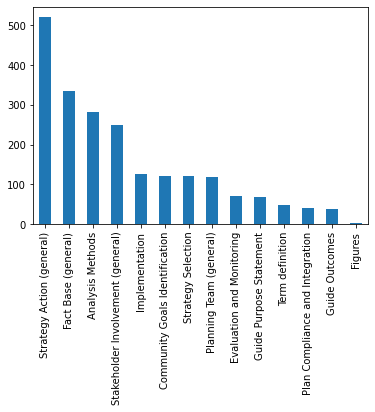

In [7]:
# class frequencies, show imbalance

display(df['tag_1'].value_counts())

df['tag_1'].value_counts().plot.bar()

In [8]:
# tfidf features

# tfidf_lim = TfidfVectorizer(min_df=0.025, max_df=0.975, stop_words='english', lowercase=True, ngram_range=(1,2))
tfidf_lim = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2), min_df=2, max_df=0.99)

In [9]:
# topic model features

with open(f'data/topic_features/ras_features_{14}_topics.npy','rb+') as f:
    topic_features = np.load(f)
    print(topic_features.shape)
    
# topic_features = np.delete(topic_features, list(dropped_indices), 0) # drop rows
# topic_features.shape

(2142, 14)


In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


def run_ML_pipeline(features,labels,model="logistic"):
    
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, random_state=53)

#     classifier = LogisticRegression(multi_class="multinomial")
    if model == 'logistic':
        classifier = SGDClassifier('log')
    elif model == 'dummy':
        classifier = DummyClassifier(strategy="most_frequent")
#         classifier = DummyClassifier(strategy="stratified")
        
    classifier.fit(X_train, y_train)

    preds = classifier.predict(X_test)

    score = accuracy_score(y_test, preds)
    print(f"The accuracy of the {model} classifier on the test set is %.3f" % score)
    
    return classifier, preds, score


# tfidf
tfidf_features = tfidf_lim.fit_transform(text)
print('tfidf_features', tfidf_features.shape)

# baseline guesser
run_ML_pipeline(tfidf_features,labels,model='dummy')
run_ML_pipeline(tfidf_features,labels)

# topics only
print('topic features')
print(topic_features.shape)
run_ML_pipeline(topic_features,labels)

# join tfidf with topic features
print('combined features')
combined_features = np.concatenate((tfidf_features.toarray(), topic_features), axis=1)
print(combined_features.shape)

_,_,_ = run_ML_pipeline(combined_features,labels)

tfidf_features (2141, 22963)
The accuracy of the dummy classifier on the test set is 0.242
The accuracy of the logistic classifier on the test set is 0.632
topic features
(2142, 14)


ValueError: Found input variables with inconsistent numbers of samples: [2142, 2141]

In [11]:
# number of topics v model accuracy

from os import path
from collections import defaultdict

limit=40; start=2; step=6;
n_range = range(start, limit, step)

features_dir = "data/topic_features"

metrics = defaultdict(list)

for num_topics in n_range:
    features_path = path.join(features_dir, f'ras_features_{num_topics}_topics.npy')
    topic_features = np.load(features_path)
    
    print(f'{num_topics} topics')
    _,_,accuracy = run_ML_pipeline(topic_features,labels)
    metrics['topic_features'].append(accuracy)
    
    combined_features = np.concatenate((tfidf_features.toarray(), topic_features), axis=1)
    _,_,accuracy = run_ML_pipeline(combined_features,labels)
    metrics['combined_features'].append(accuracy)


metrics['num_topics'] = n_range


2 topics


ValueError: Found input variables with inconsistent numbers of samples: [2142, 2141]

In [ ]:
pd.DataFrame(metrics).plot(x='num_topics', title='Model Accuracy Against Number of Topics')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, 
                                                test_size=0.2, random_state=53)

X_train.shape

In [21]:
# online learning experiments: simulate annotation
from sklearn.linear_model import Perceptron
import time

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'logistic': SGDClassifier('log'),
    'svm': SGDClassifier('hinge'),
#     'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
#     'Passive-Aggressive': PassiveAggressiveClassifier(),
}


# # test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

# minibatch size: online learning is 1 
minibatch_size = 8
minibatches = []

# X = combined_features
X = tfidf_features
y = np.array(labels)
# X = X_train
# y = y_train

i=0
# while i+minibatch_size<len(X_train):
#     minibatches.append((X_train[i:i+minibatch_size],y_train[i:i+minibatch_size]))
#     i+=minibatch_size
while i+minibatch_size<X.shape[0]:
    minibatches.append((X[i:i+minibatch_size], labels[i:i+minibatch_size]))
    i+=minibatch_size
# add the remaining examples
# minibatches.append((X[i:], labels[i:]))

print(len(minibatches))


267


In [40]:
%%time


all_classes = unique_labels


# Main loop : iterate on mini-batchs of examples
# for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

def train_one_epoch(record_iter=128):
    for i, (X_batch, y_train) in enumerate(minibatches):

        tick = time.time()
    #     X_train = vectorizer.transform(X_train_text)
    #     total_vect_time += time.time() - tick

        for cls_name, cls in partial_fit_classifiers.items():
            tick = time.time()
            # update estimator with examples in the current mini-batch
            cls.partial_fit(X_batch, y_train, classes=all_classes)

            cls_stats[cls_name]['n_train'] += X_batch.shape[0]

            if i*minibatch_size % record_iter == 0: # accumulate test accuracy stats
                print(progress(cls_name, cls_stats[cls_name]))
                
#                 tick = time.time()
#                 cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
                cls_stats[cls_name]['accuracy'] = cls.score(X, y)
                acc_history = (cls_stats[cls_name]['accuracy'],
                               cls_stats[cls_name]['n_train'])
                cls_stats[cls_name]['accuracy_history'].append(acc_history)
            #         run_history = (cls_stats[cls_name]['accuracy'],
            #                        total_vect_time + cls_stats[cls_name]['total_fit_time'])

                run_history = (cls_stats[cls_name]['accuracy'],)
                cls_stats[cls_name]['runtime_history'].append(run_history)

#         if i % 3 == 0:
#             print('\n')

epochs = 1
for j in range(epochs):
    train_one_epoch()

            logistic classifier : 	  6416 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.980 in 3311.77s (    1 docs/s)
                 svm classifier : 	  6416 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.991 in 3311.79s (    1 docs/s)
      NB Multinomial classifier : 	  6416 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.985 in 3311.81s (    1 docs/s)
            logistic classifier : 	  6544 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.981 in 3312.35s (    1 docs/s)
                 svm classifier : 	  6544 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.992 in 3312.37s (    1 docs/s)
      NB Multinomial classifier : 	  6544 train docs (     0 positive)      0 test docs (     0 positive) accuracy: 0.985 in 3312.39s (    1 docs/s)
            logistic classifier : 	  6672 train docs (     0 positive)      0 test docs (     0 positive) 

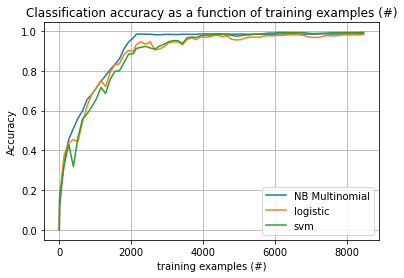

In [41]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# plot number of docs labelled against model accuracy


rcParams['legend.fontsize'] = 10

###############################################################################
# Plot results
###############################################################################


def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10

def plot_stats(cls_stats):
    cls_names = list(sorted(cls_stats.keys()))

    # Plot accuracy evolution
    plt.figure()
    for _, stats in sorted(cls_stats.items()):
        # Plot accuracy evolution with #examples
        accuracy, n_examples = zip(*stats['accuracy_history'])
        plot_accuracy(n_examples, accuracy, "training examples (#)")
        ax = plt.gca()
    #     ax.set_ylim((0.8, 1))
    plt.legend(cls_names, loc='best')

plot_stats(cls_stats)

logistic
number of confident predictions: 1794


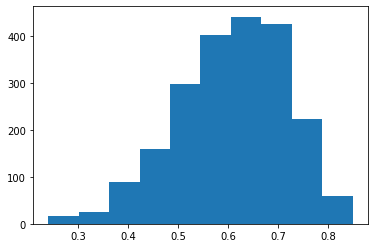

NB Multinomial
number of confident predictions: 2116


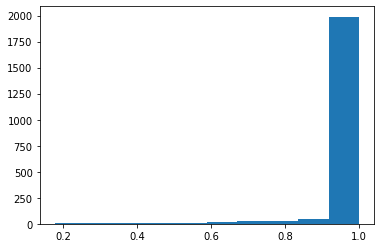

In [43]:
# is the model confident? histogram of confidence scores

for k,model in partial_fit_classifiers.items():
    if k != 'svm': # SVM doesn't support predict_proba
        print(k)
        conf_scores = model.predict_proba(X)
#         print(conf_scores.shape)
        pred_scores = conf_scores.max(axis=1)
#         print(conf_scores)
#         print(pred_scores)
        print(f'number of confident predictions: {(pred_scores > 0.5).sum()}')
        plt.hist(pred_scores)
        plt.show()

# partial_fit_classifiers = {
#     'logistic': SGDClassifier('log'),
#     'svm': SGDClassifier('hinge'),
# #     'Perceptron': Perceptron(),
#     'NB Multinomial': MultinomialNB(alpha=0.01),
# #     'Passive-Aggressive': PassiveAggressiveClassifier(),
# }

In [ ]:
# labelled topic model




In [24]:
stats = cls_stats['NB Multinomial']
accuracy, n_examples = zip(*stats['accuracy_history'])


In [25]:
ol_stats = pd.DataFrame(cls_stats['NB Multinomial']['accuracy_history'], columns=['accuracy','train_iter'])
al_stats = pd.DataFrame(active_learner_stats['naive_bayes']['accuracy_history'], columns=['accuracy','train_iter'])


merged = ol_stats.merge(al_stats, on='train_iter', how='outer')
ax = merged.plot(x='train_iter',y=['accuracy_x','accuracy_y'])
ax.set_xlim(0,3000)

NameError: name 'active_learner_stats' is not defined

In [ ]:
y = np.array(y)


In [ ]:
%%time

# active learning

from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier

# initializing the learner
# learner = ActiveLearner(
#     estimator=MultinomialNB(alpha=0.01),
#     X_training=minibatch[0][0], y_training=minibatch[0][1]
# )
active_learners = {
    'naive_bayes': ActiveLearner(
    estimator=MultinomialNB(alpha=0.01),
    X_training=minibatches[0][0], y_training=minibatches[0][1]
)
}

active_learner_stats = {}

for cls_name in active_learners:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time()}
    active_learner_stats[cls_name] = stats

record_iter = 64
batch_size = 64

for i in range(X.shape[0]//batch_size):
    for cls_name, learner in active_learners.items():
        
        query_idx, query_inst = learner.query(X, batch_size)
#         query_idx = query_idx[0]
#         print(query_idx)
#         print(y[query_idx])

#         learner.teach([X[query_idx]], [y[query_idx]])
        learner.teach(query_inst, y[query_idx])
        
        active_learner_stats[cls_name]['n_train'] += batch_size

        if i*batch_size % record_iter == 0: # accumulate test accuracy stats

            cls = learner

#                 tick = time.time()
            active_learner_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
#                 active_learner_stats[cls_name]['accuracy'] = cls.score(X, y)
            acc_history = (active_learner_stats[cls_name]['accuracy'],
                           active_learner_stats[cls_name]['n_train'])
            active_learner_stats[cls_name]['accuracy_history'].append(acc_history)
        #         run_history = (active_learner_stats[cls_name]['accuracy'],
        #                        total_vect_time + active_learner_stats[cls_name]['total_fit_time'])

#             run_history = (active_learner_stats[cls_name]['accuracy'],)
#             active_learner_stats[cls_name]['runtime_history'].append(run_history)
            
            print(progress(cls_name, active_learner_stats[cls_name]))


In [ ]:
# rcParams['legend.fontsize'] = 10
cls_names = list(sorted(active_learner_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(active_learner_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
#     ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

In [ ]:
active_learner_stats

In [ ]:
# dir(learner.query)
learner.query.__code__.co_varnames

In [ ]:
ma = price.rolling(20).mean()

mstd = price.rolling(20).std()

In [ ]:
# what are the features?

# inspect model
class_labels = classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_lim.get_feature_names()

# Zip the feature names together with the coefficient array 
# and sort by weights: feat_with_weights
# feat_with_weights = sorted(zip(classifier.coef_[0], feature_names), reverse=True)
# display(feat_with_weights[:10])
# display(feat_with_weights[-10:])

# Print the first class label and the top 20 feat_with_weights entries
for i in range(10):
    label = class_labels[i]
    print(label, precision_scores[label])
    
    feat_with_weights = sorted(zip(classifier.coef_[i], feature_names), reverse=True)
    display(feat_with_weights[:10])
    display(feat_with_weights[-10:])
    
# # Print the second class label and the bottom 20 feat_with_weights entries
# print(class_labels[1], feat_with_weights[-20:])

In [ ]:
print(X_train.shape, len(y_train))

In [ ]:
# reverse engineer the .feat file

import sklearn

features_path = "data/synthetic/output/T5/init/synthetic.feat"

X, y = sklearn.datasets.load_svmlight_file(features_path)

print(X.shape, y.shape)


# cluster quality: purity, etc

In [ ]:
# X.toarray()
y

In [ ]:
!ls data